<a href="https://colab.research.google.com/github/ali-farshad/Homework1-ME5920/blob/main/3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import zipfile, os, glob
import numpy as np
import matplotlib.pyplot as plt

zip_path = "Agricultural_Image_Analytics.zip"
extract_dir = "Agricultural_Image_Analytics"


os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_dir)

img_paths = []
for ext in ["png"]:
    img_paths += glob.glob(os.path.join(extract_dir, "**", f"*.{ext}"), recursive=True)

print("Number of images found:", len(img_paths))
print("Example path:", img_paths[0] if len(img_paths)>0 else "No images found!")


Number of images found: 8
Example path: Agricultural_Image_Analytics/Agricultural_Image_Analytics/leaves/I5.png


Image size: (347, 382)


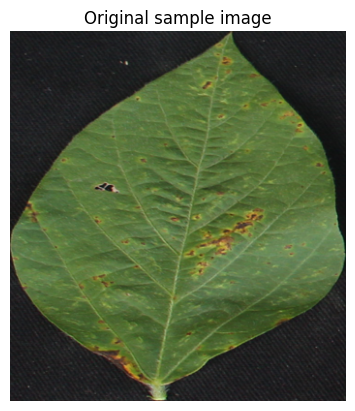

In [5]:
from PIL import Image

img0 = Image.open(img_paths[0]).convert("RGB")
print("Image size:", img0.size)

plt.figure()
plt.imshow(img0)
plt.title("Original sample image")
plt.axis("off")
plt.show()

In [6]:
import random
from PIL import ImageOps

def random_augment(pil_img):
    w, h = pil_img.size

    # 1) rotate
    angle = random.uniform(-25, 25)
    img = pil_img.rotate(angle, resample=Image.BILINEAR, expand=False)

    # 2) scale (zoom in/out)
    scale = random.uniform(0.8, 1.2)
    nw, nh = int(w*scale), int(h*scale)
    img_scaled = img.resize((nw, nh), resample=Image.BILINEAR)


    if scale >= 1.0:
        left = (nw - w)//2
        top  = (nh - h)//2
        img_scaled = img_scaled.crop((left, top, left+w, top+h))
    else:
        pad_left = (w - nw)//2
        pad_top  = (h - nh)//2
        img_scaled = ImageOps.expand(img_scaled, border=(pad_left, pad_top, w-nw-pad_left, h-nh-pad_top), fill=0)

    # 3) shift (translation)
    tx = random.randint(-20, 20)
    ty = random.randint(-20, 20)
    img_shift = Image.fromarray(np.roll(np.roll(np.array(img_scaled), ty, axis=0), tx, axis=1))

    # 4) warp (affine)
    arr = np.array(img_shift)
    img_warp = Image.fromarray(arr).transform(
        (w, h),
        Image.AFFINE,
        (1, random.uniform(-0.15, 0.15), 0,
         random.uniform(-0.15, 0.15), 1, 0),
        resample=Image.BILINEAR
    )
    return img_warp

aug_dir = "augmented_100"
os.makedirs(aug_dir, exist_ok=True)

aug_images = []
for i in range(100):
    out = random_augment(img0)
    aug_images.append(out)
    out.save(os.path.join(aug_dir, f"aug_{i:03d}.png"))

print("Saved 100 augmented images to:", aug_dir)


Saved 100 augmented images to: augmented_100


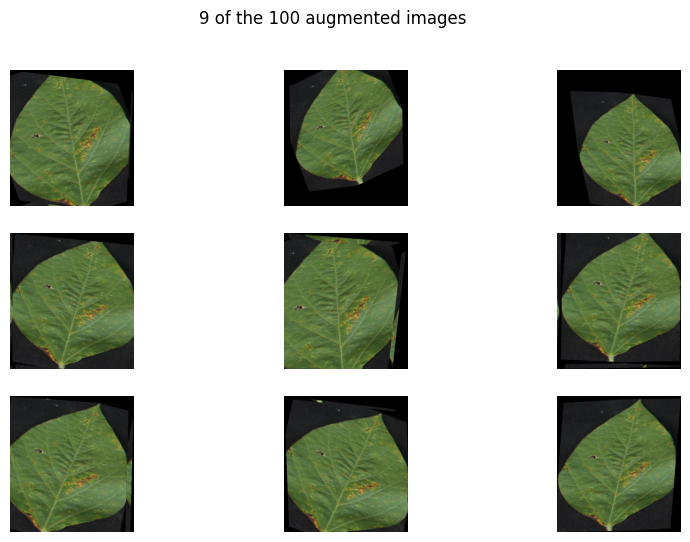

In [7]:
plt.figure(figsize=(10,6))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(aug_images[i])
    plt.axis("off")
plt.suptitle("9 of the 100 augmented images")
plt.show()

In [8]:
patch_size = 64
patches = []

def random_patch(pil_img, p=64):
    img = pil_img.convert("RGB")
    w, h = img.size
    if w < p or h < p:
        img = img.resize((max(w,p), max(h,p)))
        w, h = img.size
    x = random.randint(0, w-p)
    y = random.randint(0, h-p)
    patch = img.crop((x, y, x+p, y+p))
    return np.array(patch, dtype=np.float32) / 255.0

for path in img_paths:
    img = Image.open(path).convert("RGB")
    patches.append(random_patch(img, patch_size))

patches = np.stack(patches, axis=0)
print("patches shape:", patches.shape)


patches shape: (8, 64, 64, 3)


In [9]:
import numpy as np

def zca_whiten_fast(X, eps=0.5):
    N, H, W, C = X.shape
    Xf = X.reshape(N, -1).astype(np.float32)
    mean = Xf.mean(axis=0, keepdims=True)
    Xc = Xf - mean
    G = (Xc @ Xc.T) / N
    U, S, _ = np.linalg.svd(G, full_matrices=False)

    # whitening in sample-space then map back
    inv_sqrt = np.diag(1.0 / np.sqrt(S + eps))
    Xw = (U @ inv_sqrt @ U.T @ Xc)

    return Xw.reshape(N, H, W, C), mean

patches_zca, patches_mean = zca_whiten_fast(patches, eps=1e-5)
print("ZCA patches shape:", patches_zca.shape)
print("mean shape:", patches_mean.shape)


ZCA patches shape: (8, 64, 64, 3)
mean shape: (1, 12288)


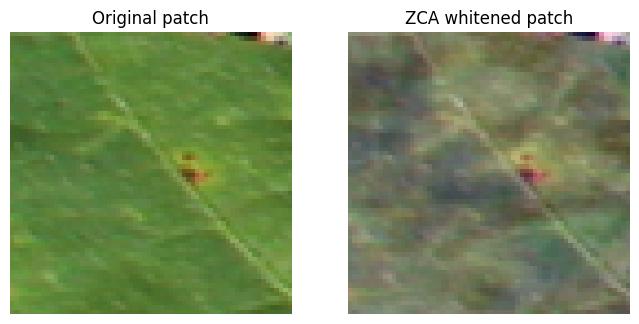

In [10]:
def show_img(img, title=""):
    a = img.copy()
    a = (a - a.min()) / (a.max() - a.min() + 1e-9)
    plt.imshow(a)
    plt.title(title)
    plt.axis("off")

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); show_img(patches[0], "Original patch")
plt.subplot(1,2,2); show_img(patches_zca[0], "ZCA whitened patch")
plt.show()

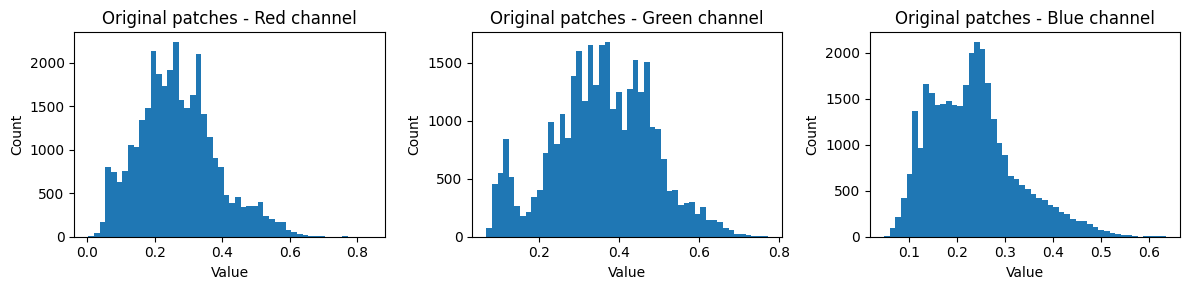

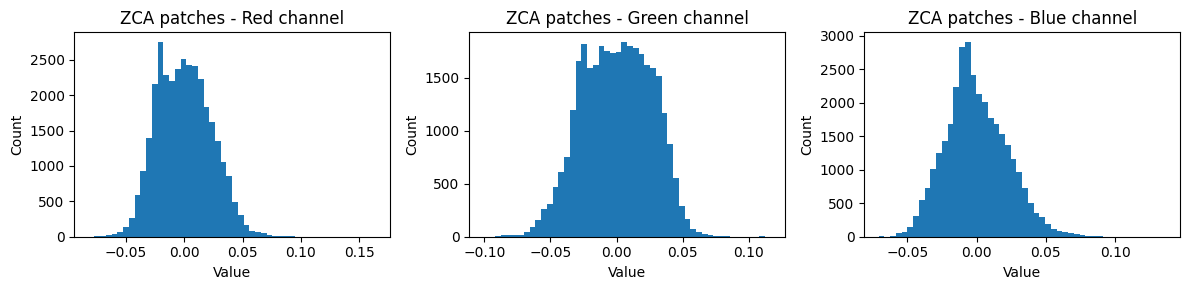

In [11]:
def plot_channel_hist(X, title_prefix="Original"):
    # X: (N,H,W,C)
    channels = ["Red", "Green", "Blue"]
    plt.figure(figsize=(12,3))
    for c in range(3):
        data = X[:,:,:,c].ravel()
        plt.subplot(1,3,c+1)
        plt.hist(data, bins=50)
        plt.title(f"{title_prefix} - {channels[c]} channel")
        plt.xlabel("Value")
        plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

plot_channel_hist(patches, "Original patches")
plot_channel_hist(patches_zca, "ZCA patches")